In [1]:
import overpy
import numpy as np
import fitparse
from rdp import rdp
import pandas as pd
import math
from geopy import distance
from tqdm import tqdm

# Import Fitfile and read all waypoints into array
+ and convert position into degrees

In [2]:
file = "Fahrt_am_Nachmittag.fit"
fitfile = fitparse.FitFile(file)
lat_long = []
for record in fitfile.get_messages("record"):
    lat_long.append([float(record.get_value('position_lat')) * 180 / math.pow(2, 31), float(record.get_value('position_long')) * 180 / math.pow(2, 31)])

# Optimze Map by using rdp to reduce requests:

In [3]:
def optimize(lat_long, EPSILON=0.0001):
    arr = np.array(list(map(lambda lat, lon: [lat, lon], lat_long[0], lat_long[1])))
    mask = rdp(arr, algo="iter", return_mask=True, epsilon=EPSILON)
    parr = np.array(lat_long)
    r = list(parr[mask])
    return r

In [4]:
# slicing array due private area reasons
df = pd.DataFrame(lat_long[500:-500])
print(f'Rawfile: {len(df)} Points')
# optimize array
_optimized = optimize(df)
print(f'Optimized: {len(_optimized)} Points')


Rawfile: 5223 Points
Optimized: 99 Points


# Variant 1:

Build Query with all Waypoints and add distance to array for DataFrame usage

In [5]:
around = 6
tmp = []
s = ""
for a in range(0, len(_optimized )-1):
    tmp.append( [_optimized [a][0],  _optimized [a][1], distance.distance((_optimized [a][0], _optimized [a][1]), (_optimized [a+1][0], _optimized [a+1][1])).km])
    lat_mean = ( _optimized [a][0] + _optimized [a+1][0] ) / 2
    lon_mean = ( _optimized [a][1] + _optimized [a+1][1] ) / 2
    s += f"way['surface'](around:{around},{lat_mean}, {lon_mean});"
q = f"[out:json];({s});(._;>;);out;"
#print(q)

In [6]:
#print(q)

In [7]:
_df = pd.DataFrame(tmp, columns=['lat','lon','distance'])
_df.shape

(98, 3)

In [8]:
_df.head()

,lat,lon,distance
0,51.976537,7.601682,1.088618
1,51.983330,7.590279,0.138327
2,51.984269,7.588961,0.054852
3,51.984523,7.588277,1.042844
4,51.990946,7.577222,0.247170


# Query overpass by using generated long query

In [9]:
urls = ['https://lz4.overpass-api.de/api/interpreter', 'https://z.overpass-api.de/api/interpreter', 'https://maps.mail.ru/osm/tools/overpass/api/interpreter', 'https://overpass.openstreetmap.ru/api/interpreter', 'https://overpass.kumi.systems/api/interpreter']
url = np.random.choice(urls)
print(url)
api = overpy.Overpass()
result = api.query(q)

https://overpass.openstreetmap.ru/api/interpreter


In [10]:
len( result.ways )

56

In [11]:
# overpass ways and nodes to df
overpass_df = pd.DataFrame()
c = 0
for way in result.ways:
    for node in way.get_nodes(resolve_missing=True):
        overpass_df.loc[c , 'node_lat'] = node.lat
        overpass_df.loc[c , 'node_lon'] = node.lon
        overpass_df.loc[c , 'node_id'] =  node.id
        overpass_df.loc[c , 'waysurface'] = way.tags['surface']
        if 'name' in way.tags.keys():
            overpass_df.loc[c , 'wayname'] = way.tags['name']
        c += 1
        
overpass_df.index = overpass_df['node_id']
#overpass_df = overpass_df.dropna()
overpass_df = overpass_df.loc[ ~overpass_df.index.duplicated() ]
#overpass_df = overpass_df.loc[ overpass_df.duplicated() ]
#overpass_df['wayname'].dropna()

In [12]:
overpass_df.shape

(675, 5)

In [13]:
# get nearest node per waypoint

for index, x in tqdm( _df[['lat','lon']].iterrows(), total=_df.shape[0]):
    tmp_df = pd.DataFrame()
    tmp_df['d'] = overpass_df.apply( lambda y: distance.distance((y['node_lat'], y['node_lon']),(x['lat'], x['lon'])).m, axis=1 )
    _df.loc[index, 'surface' ] =  overpass_df.loc[ tmp_df['d'].idxmin(axis=0) ]['waysurface']
    _df.loc[index, 'wayname' ] =  overpass_df.loc[ tmp_df['d'].idxmin(axis=0) ]['wayname']
    _df.loc[index, 'node_id' ] =  overpass_df.loc[ tmp_df['d'].idxmin(axis=0) ]['node_id']
    _df.loc[index, 'distance2waypoint' ] =  tmp_df['d'].loc[ tmp_df['d'].idxmin(axis=0) ]
print(_df)

100%|██████████| 98/98 [00:13<00:00,  7.10it/s]

          lat       lon  distance    surface                    wayname  \
0   51.976537  7.601682  1.088618    asphalt                        NaN   
1   51.983330  7.590279  0.138327    asphalt                        NaN   
2   51.984269  7.588961  0.054852    asphalt                        NaN   
3   51.984523  7.588277  1.042844    asphalt                        NaN   
4   51.990946  7.577222  0.247170  compacted  Landfahrerplatz Nienberge   
..        ...       ...       ...        ...                        ...   
93  52.192706  7.446302  0.040392    asphalt                   Torfvenn   
94  52.192563  7.446845  0.891835    asphalt                   Torfvenn   
95  52.193789  7.459733  0.235076    asphalt                   Torfvenn   
96  52.192914  7.462863  0.383535    asphalt                    Im Venn   
97  52.189527  7.463905  0.223215    asphalt                    Im Venn   

         node_id  distance2waypoint  
0   2.433302e+08         365.653693  
1   5.127044e+09       

In [14]:
summary_df = pd.DataFrame()
for s in np.unique( _df['surface'].dropna() ):
    summary_df.loc[0, s] = (_df['distance'].loc[_df['surface'] == s]).sum()

<AxesSubplot: >

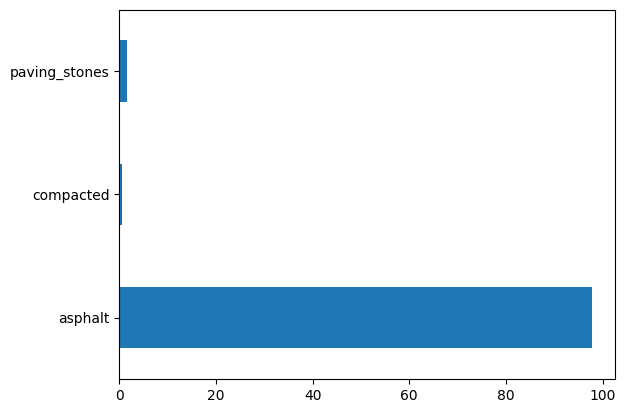

In [15]:
summary_df.apply(lambda x: x/_df['distance'].sum()*100 ).T.plot(kind="barh", legend=False)

# Variant 2. 
Loop through Dataframe and get nearest way. One reuquest for one Waypoint in optimized track.

In [16]:
def get_way(lat,lon):
    # load balancing requests
    urls = ['https://lz4.overpass-api.de/api/interpreter', 'https://z.overpass-api.de/api/interpreter', 'https://maps.mail.ru/osm/tools/overpass/api/interpreter', 'https://overpass.openstreetmap.ru/api/interpreter', 'https://overpass.kumi.systems/api/interpreter']
    around = 10
    _name = None
    _surface = None
    s = f"way['surface'](around:{around},{lat}, {lon});"
    _query = f"[out:json];({s});out;"
    # print(_query)
    api = overpy.Overpass(url=np.random.choice(urls))
    result = api.query(_query)
    
    if len(result.ways) > 0:
        way = result.ways[0]
        if "name" in way.tags.keys():
            _name = way.tags['name']
        if "surface" in way.tags.keys():
            _surface = way.tags['surface']
    return [_name, _surface]

In [17]:
# loop dataframe and catch nearest street. Much more requests than variant 1
for index, x in tqdm( _df[['lat','lon']].iterrows(), total=_df.shape[0]):
    r =  get_way(x['lat'], x['lon']) 
    _df.loc[index, 'street_name'] = r[0]
    _df.loc[index, 'surface'] = r[1]

100%|██████████| 98/98 [01:23<00:00,  1.17it/s]


In [18]:
_df.tail()

,lat,lon,distance,surface,wayname,node_id,distance2waypoint,street_name
93,52.192706,7.446302,0.040392,asphalt,Torfvenn,6.493177e+08,14.573405,Torfvenn
94,52.192563,7.446845,0.891835,asphalt,Torfvenn,2.666664e+08,19.899867,Torfvenn
95,52.193789,7.459733,0.235076,asphalt,Torfvenn,2.666664e+08,2.477437,Torfvenn
96,52.192914,7.462863,0.383535,asphalt,Im Venn,7.116629e+09,4.454344,Torfvenn
97,52.189527,7.463905,0.223215,asphalt,Im Venn,2.667140e+08,12.885283,Im Venn


In [19]:
np.unique( _df['surface'].dropna() )

array(['asphalt', 'cobblestone', 'compacted', 'grass', 'paving_stones'],
      dtype=object)

In [20]:
summary_df = pd.DataFrame()
for s in np.unique( _df['surface'].dropna() ):
    summary_df.loc[0, s] = (_df['distance'].loc[_df['surface'] == s]).sum()

In [21]:
# Distance by surface
summary_df

,asphalt,cobblestone,compacted,grass,paving_stones
0,40.42923,0.111936,0.030319,0.340597,1.000677


In [22]:
# get in P%
summary_df.apply(lambda x: x/_df['distance'].sum()*100 )

,asphalt,cobblestone,compacted,grass,paving_stones
0,89.525303,0.247868,0.067137,0.754207,2.215869


<AxesSubplot: >

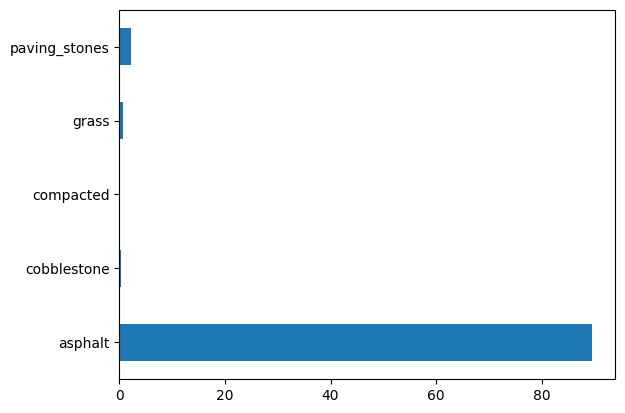

In [23]:
summary_df.apply(lambda x: x/_df['distance'].sum()*100 ).T.plot(kind="barh", legend=False)